In [120]:
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from PIL import Image
from tqdm import tqdm
import glob
from transformers import get_cosine_schedule_with_warmup
from transformers import CLIPModel, CLIPProcessor

# Building the dataset

In [121]:
# Creating the dataset!!!
# I'm using 30,000 randomly selected images and their captions from the loc.gov API

import pandas as pd 
import random, os, requests, json
from datetime import datetime
os.chdir("/Users/jamiemahowald/Documents/Python/Fine-tuning")

merged_files = pd.read_csv("merged_files.csv")
list_image_path = torch.load("list_image_path.pt")
list_txt = torch.load("list_txt.pt")
print(len(list_image_path), len(list_txt))

25344 25344


In [16]:
# Get a caption for the model from loc.gov API

def get_resource(row):
    iiif_url = merged_files.iloc[row]['file_url'].replace("pct:100", "2000,")
    resource_json_url = merged_files.iloc[row]['resource_url']+"?fo=json&sp=" + str(int(merged_files.iloc[row]['segment_num']+1))
    response = requests.get(resource_json_url)
    if response.status_code == 200:
        resource_dict = response.json()
        return iiif_url, resource_dict
    else:
        print(f"First invalid identifier {resource_json_url}. Status code: {response.status_code}")
        return None, None
    
def remove_last_period(s):
    pos = s.rfind('.')
    if pos == len(s) - 1:
        return s[:pos] + ","
    return s

def get_caption(row_num):
    iiif_url, resource_dict = get_resource(row_num)
    with open("example_json.json", "w") as file:
        json.dump(resource_dict, file, indent = 4)
    if iiif_url is None:
        return None, None
    else:
        if not "map" in resource_dict['item']['title'].lower():
            resource_dict['item']['title'] = "Map of " + resource_dict['item']['title'] 
        try:
            date_obj = datetime.strptime(resource_dict['item']['date'], "%Y-%m-%d")
            formatted_date = date_obj.strftime("%B %d, %Y")
        except ValueError:
            try:
                date_obj = datetime.strptime(resource_dict['item']['date'], "%Y-%m")
                formatted_date = date_obj.strftime("%B %Y") 
            except ValueError:
                formatted_date = resource_dict['item']['date']
        if "January 01" in formatted_date:
            formatted_date = formatted_date.replace("January 01, ", "")
        title = remove_last_period(resource_dict['item']['title']) + " from " + formatted_date
        return iiif_url, title    

# Fine-tuning

In [32]:
rand_ints = random.sample(range(300000, len(merged_files)), 50)

list_image_path = []
list_txt = []

for i in tqdm(rand_ints, desc = "Downloading image: "):
    iiif_url, title = get_caption(i)
    if iiif_url is None:
        continue
    iiif_id = iiif_url.split("/")[-5]
    response = requests.get(iiif_url)
    with open(f"images/train/{iiif_id}.jpg", "wb") as file:
        file.write(response.content)

    list_image_path.append(f"images/train/{iiif_id}.jpg")
    list_txt.append(title)

In [22]:
import clip
BATCH_SIZE = 4
EPOCH = 10

device = "cuda:0" if torch.cuda.is_available() else "cpu" # If using GPU then use mixed precision training.
model, preprocess = clip.load("ViT-B/32",device=device,jit=False) #Must set jit=False for training

class image_title_dataset(Dataset):
    def __init__(self, list_image_path,list_txt):

        self.image_path = list_image_path
        self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.

    def __len__(self):
        return len(self.title)

    def __getitem__(self, idx):
        image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
        title = self.title[idx]
        return image,title

# use your own data
dataset = image_title_dataset(list_image_path,list_txt)
train_dataloader = DataLoader(dataset,batch_size = BATCH_SIZE) #Define your own dataloader

#https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 


if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model) # Actually this line is unnecessary since clip by default already on float16

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2) #Params used from paper, the lr is smaller, more safe for fine tuning to new dataset

# add your own code to track the training progress.
for epoch in tqdm(range(EPOCH), desc = "Epoch loading: "):
  for batch in train_dataloader :
      optimizer.zero_grad()

      images,texts = batch 
    
      images= images.to(device)
      texts = texts.to(device)
    
      logits_per_image, logits_per_text = model(images, texts)

      ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

      total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
      total_loss.backward()
      if device == "cpu":
         optimizer.step()
      else : 
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)

Epoch loading: 100%|██████████| 10/10 [00:26<00:00,  2.61s/it]


In [25]:
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss,
        }, f"fine_tuned_clip.pt") #just change to your preferred folder/filename

In [3]:
import random
import torch
import pandas as pd
merged_files = pd.read_csv("merged_files.csv")

In [22]:
list_image_path = torch.load("list_image_path.pt")
list_txt = torch.load("list_txt.pt")
num = 45010
link = "https://tile.loc.gov/image-services/iiif/" + list_image_path[num].split("/")[-1].replace(".jpg", "") + "/full/pct:50/0/default.jpg"
display(link, list_txt[num])

'https://tile.loc.gov/image-services/iiif/service:gmd:gmd380:g3804:g3804o:pm010990/full/pct:50/0/default.jpg'

'A map of Oriskany Falls, N.Y, from 1891. Aerial view of village. LC copy imperfect: Torn, taped, fold-lined, faded, stained at lower edge. Includes index to points of interest.'

In [56]:
df = pd.DataFrame({"path": list_image_path, "title": list_txt})
print(df.path.duplicated().sum())
for path in df.path[df.path.duplicated()].values:
    print(df[df.path == path].title.values)


1
['Maps of California--regions San Jacinto-San M, from 1800.'
 'Maps of California--regions San Jacinto-San M, from 1800.']


# Dataset creation

In [7]:
# figuring shit out
import torch
from transformers import CLIPModel, CLIPProcessor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os, torch
from tqdm import tqdm
import torch.nn as nn #Keep if changing loss function
import torch.optim as optim
import torch.nn.functional as Floss

os.chdir("/Users/jamiemahowald/Documents/Python/Fine-tuning")
list_image_path = torch.load("list_image_path.pt")
list_image_path = list_image_path[0:2000]
list_txt = torch.load("list_txt.pt")
list_txt = list_txt[0:2000]

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [83]:
# Defining the image_title_datset class (image & path always come before text)
class image_title_dataset(Dataset):
    def __init__(self, list_image_path, list_txt):
        self.image_path = list_image_path
        self.texts = list_txt

    def __len__(self):
        return len(self.texts) if len(self.texts) == len(self.image_path) else Exception
    
    def __getitem__(self, idx):
        image_path = self.image_path[idx]
        text = self.texts[idx]
        return image_path, text

In [85]:
def collate_fn(batch):
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    texts = []
    images = []

    for item in batch:
        try:
            image = Image.open(item[0]).convert("RGB")
            images.append(image)
            texts.append(item[1])
        except:
            continue

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)
    return batch

In [86]:
LEARNING_RATE = 2e-5
TEMPERATURE = 0.07
EPOCH = 1

dataset = image_title_dataset(list_image_path, list_txt)
train_dataloader = DataLoader(dataset, batch_size = 10, collate_fn = collate_fn, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

In [87]:
for epoch in range(15):
    print(f"Starting epoch {epoch+1}")
    total_loss = 0  # Initialize total loss for the epoch

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCH}", unit="batch"):
        # Assuming `batch` is a dictionary or BatchEncoding object returned by the tokenizer
        optimizer.zero_grad()
        # Prepare inputs and forward pass
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)

        # Get the logits from the model
        logits_per_image, logits_per_text = outputs.logits_per_image, outputs.logits_per_text

        # Calculate the symmetric InfoNCE loss
        sim_image_text = logits_per_image / TEMPERATURE
        sim_text_image = logits_per_text / TEMPERATURE

        labels = torch.arange(sim_image_text.size(0), device=device)

        # Calculate the loss for both image-to-text and text-to-image
        loss_img = Floss.cross_entropy(sim_image_text, labels)
        loss_txt = Floss.cross_entropy(sim_text_image, labels)

        # Combine the losses and update total loss
        loss = (loss_img + loss_txt) / 2
        total_loss += loss.item()  # Accumulate the loss
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(train_dataloader)  # Calculate average loss
    print(f"Epoch {epoch+1}/{EPOCH}, Total Loss: {total_loss}")
    print(f"Epoch {epoch+1}/{EPOCH}, Average Loss: {avg_loss}")

Starting epoch 1


Epoch 1/1: 100%|██████████| 200/200 [10:05<00:00,  3.03s/batch]


Epoch 1/1, Total Loss: 679.6482626199722
Epoch 1/1, Average Loss: 3.398241313099861
Starting epoch 2


Epoch 2/1: 100%|██████████| 200/200 [09:43<00:00,  2.92s/batch]


Epoch 2/1, Total Loss: 358.2243068218231
Epoch 2/1, Average Loss: 1.7911215341091156
Starting epoch 3


Epoch 3/1: 100%|██████████| 200/200 [09:14<00:00,  2.77s/batch]


Epoch 3/1, Total Loss: 356.58969032764435
Epoch 3/1, Average Loss: 1.7829484516382217
Starting epoch 4


Epoch 4/1: 100%|██████████| 200/200 [09:09<00:00,  2.75s/batch]


Epoch 4/1, Total Loss: 347.07016694545746
Epoch 4/1, Average Loss: 1.7353508347272872
Starting epoch 5


Epoch 5/1: 100%|██████████| 200/200 [08:39<00:00,  2.60s/batch]


Epoch 5/1, Total Loss: 364.3801726102829
Epoch 5/1, Average Loss: 1.8219008630514144
Starting epoch 6


Epoch 6/1: 100%|██████████| 200/200 [08:29<00:00,  2.55s/batch]


Epoch 6/1, Total Loss: 366.3358316421509
Epoch 6/1, Average Loss: 1.8316791582107543
Starting epoch 7


Epoch 7/1: 100%|██████████| 200/200 [08:42<00:00,  2.61s/batch]


Epoch 7/1, Total Loss: 361.5951716899872
Epoch 7/1, Average Loss: 1.807975858449936
Starting epoch 8


Epoch 8/1: 100%|██████████| 200/200 [09:36<00:00,  2.88s/batch]


Epoch 8/1, Total Loss: 380.1901181936264
Epoch 8/1, Average Loss: 1.9009505909681321
Starting epoch 9


Epoch 9/1: 100%|██████████| 200/200 [09:04<00:00,  2.72s/batch]


Epoch 9/1, Total Loss: 380.55764973163605
Epoch 9/1, Average Loss: 1.9027882486581802
Starting epoch 10


Epoch 10/1:  56%|█████▌    | 111/200 [04:46<03:50,  2.59s/batch]

: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


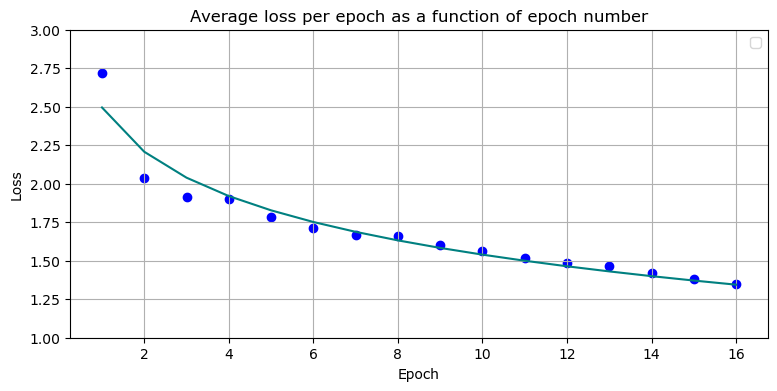

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data
epochs = np.array(range(1, 17))
losses = np.array([2.7201081, 2.037461895, 1.915202904, 1.901985966, 1.781927386, 
                   1.713426403, 1.669924718, 1.659812765, 1.604798629, 1.562448905, 
                   1.518086743, 1.485711219, 1.46616415, 1.423164273, 1.382916131, 1.349751784])

# Logarithmic fit function
def log_fit(x, a, b):
    return a + b * np.log(x)

# Fit the logarithmic function to the data
params, params_covariance = curve_fit(log_fit, epoch, losses)

# Plotting the data
font = {"fontname": "Verdana"}
plt.figure(figsize=(9, 4))
plt.scatter(epochs, losses, color='blue')
plt.plot(epochs, log_fit(epochs, *params), color='teal')
plt.title('Average loss per epoch as a function of epoch number', **font)
plt.xlabel('Epoch', **font)
plt.ylabel('Loss', **font)
plt.ylim(1, 3)
plt.legend()
plt.grid(True)
plt.show()

# Testing fine-tuned models against baseline

In [148]:
os.chdir("/Users/jamiemahowald/Documents/Python/Fine-tuning")
from transformers import CLIPProcessor, CLIPModel
import requests
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32") # Processor does not change
model_base = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") # Model does not change
model_ft = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") 
checkpoint = torch.load("fine_tuned_clip_epoch_2_bs8.pt", map_location='cpu')
model_ft.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [146]:
txt_query = "An antique sepia map of southern New England and Long Island"
img_query = "https://tile.loc.gov/image-services/iiif/service:gmd:gmd372:g3720:g3720:ar079701/full/pct:12.5/0/default.jpg"

In [149]:
# Base search
text_preprocess = processor(text=txt_query, return_tensors="pt", padding=True)
text_embeds = model_base.get_text_features(**text_preprocess)
text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

image = Image.open(requests.get(img_query, stream=True).raw)
img_preprocess = processor(images = image, return_tensors="pt", padding=True) 
img_embeds = model_base.get_image_features(**img_preprocess) 
img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)
logits = torch.matmul(img_embeds, text_embeds.t())
print(logits)

tensor([[0.3334]], grad_fn=<MmBackward0>)


In [151]:
# FT search
text_preprocess = processor(text=txt_query, return_tensors="pt", padding=True)
text_embeds = model_ft.get_text_features(**text_preprocess)
text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

image = Image.open(requests.get(img_query, stream=True).raw)
img_preprocess = processor(images = image, return_tensors="pt", padding=True) 
img_embeds = model_ft.get_image_features(**img_preprocess) 
img_embeds = img_embeds / img_embeds.norm(p=2, dim=-1, keepdim=True)
logits = torch.matmul(img_embeds, text_embeds.t())
print(logits)

tensor([[0.2567]], grad_fn=<MmBackward0>)


In [7]:
import torch
import os
os.chdir("/Users/jamiemahowald/Documents/kluge-maps/fine-tuning")
list_image_path = torch.load("list_image_path.pt")
list_txt = torch.load("list_txt.pt")
# print(list_image_path)
list_image_path = [f"images/train/{path.split('/')[-1]}" for path in list_image_path]

torch.save(list_image_path, "list_image_path.pt")